# Info 1998 Final: Rent and Climate Change
# Arnab Ghosh (ag2583), Ayan Kohli (ak2668)

The even before the pandemic, the US housing market grew dangerously hot with rent rising everywhere in the country, notably even in traditional population centers losing people. Accelerated by the tech market, many economists predicted the pandemic would help return rent values to planet earth. However, seemingly, the reverse happened: the market grew impossibly hotter, with rent values rising in many cities. 

And just as the rent in the US seems to grow at an inevitably exponential rate, so does the climate change. The pandemic has brought a temporary halt to the world's economy, and with it, a temporary halt to the world's pollution. However, as the world begins to recover, the pollution levels are expected to rise again. Already, hurricanes in Florida, droughts in California, and dangerous heat in Arizona have affected some of the hottest housing markets in the US. 

This project will explore the relationship between rent and climate change, and perhaps an insight into how the two will affect each other as climate change becomes ever more prevalent and rent values continue to rise.

**Question**: How does the risk of climate change affect rent values increase in the US?

## Loading the Data
We get our rent data from Zillow's ZORI, a zillow-provided dataset that estimates rent values in the US. We choose to use this instead of housing prices because that is subject to influence from other factors and rent values are usually pretty good indicators of housing prices anyhow. We get climate change data from the Climate Vulnerability Index, which measures the approximate effect of climate vulnerability on a given area on a county and tract basis (which we then convert to Zip Codes to use with the ZORI data).

In [6]:
# imports!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [7]:
zori_raw = pd.read_csv('zori.csv')  
zori_raw.head()

RegionID  SizeRank          RegionName RegionType StateName State  \
0      3101         0  Los Angeles County     county        CA    CA   
1       139         1         Cook County     county        IL    IL   
2      1090         2       Harris County     county        TX    TX   
3      2402         3     Maricopa County     county        AZ    AZ   
4      2841         4    San Diego County     county        CA    CA   

                                  Metro  StateCodeFIPS  MunicipalCodeFIPS  \
0    Los Angeles-Long Beach-Anaheim, CA              6                 37   
1    Chicago-Naperville-Elgin, IL-IN-WI             17                 31   
2  Houston-The Woodlands-Sugar Land, TX             48                201   
3             Phoenix-Mesa-Chandler, AZ              4                 13   
4    San Diego-Chula Vista-Carlsbad, CA              6                 73   

    2015-01-31  ...   2024-01-31   2024-02-29   2024-03-31   2024-04-30  \
0  1772.233330  ...  2781.392933  2790.984699  2806.559612  2818.306197   
1  1435.502882  ...  1959.531317  1977.697210  1994.035895  2016.505413   
2  1209.258458  ...  1617.771137  1623.586590  1627.669268  1634.432534   
3   946.265039  ...  1807.744140  1817.532983  1829.010826  1838.896814   
4  1677.175588  ...  2915.727434  2926.751971  2947.220213  2973.295343   

    2024-05-31   2024-06-30   2024-07-31   2024-08-31   2024-09-30  \
0  2832.959966  2843.172159  2855.280776  2860.267225  2866.158878   
1  2035.329287  2052.307491  2058.995184  2058.724405  2053.468827   
2  1643.115290  1651.857699  1656.103747  1659.403192  1660.990009   
3  1844.315428  1844.660359  1845.222578  1844.396037  1843.692712   
4  2992.198023  3010.152866  3021.397169  3024.128523  3021.844445   

    2024-10-31  
0  2864.485813  
1  2050.046257  
2  1661.050802  
3  1834.325759  
4  3016.945905  

[5 rows x 127 columns]

Now, we import the CVI data. This data is a bit more complicated; we want to create a baseline score by combining each statistic and creating a percentile index. We will then use this index to compare with the ZORI data.

In [8]:
cvi_raw = pd.read_csv('CVI-county-pct-comb.csv')

cvi_raw.head()

row#         Name  FIPS                    Source  ToxPi Score  \
0     1  AL, Autauga  1001  +32.5363818,-086.6444901     0.570687   
1     2  AL, Baldwin  1003  +30.6592183,-087.7460666     0.560611   
2     3  AL, Barbour  1005  +31.8706701,-085.4054562     0.650569   
3     4     AL, Bibb  1007  +33.0158929,-087.1271475     0.587425   
4     5   AL, Blount  1009  +33.9774479,-086.5672464     0.614214   

   Baseline.Health  Baseline.SocialEconomic  Baseline.Infrastructure  \
0         0.529536                 0.456048                 0.742276   
1         0.467259                 0.347616                 0.577476   
2         0.800427                 0.807919                 0.803179   
3         0.654048                 0.456367                 0.788377   
4         0.700177                 0.507878                 0.798056   

   Baseline.Environment  ClimateChange.Health  ClimateChange.SocialEconomic  \
0              0.631471              0.804263                      0.534224   
1              0.520383              0.762054                      0.640376   
2              0.407234              0.822277                      0.558273   
3              0.465466              0.824911                      0.526622   
4              0.490592              0.809642                      0.617842   

   ClimateChange.ExtremeEvents  
0                     0.296992  
1                     0.609112  
2                     0.354674  
3                     0.396182  
4                     0.375314

In [9]:
# Clean up ZORI county names by removing " County" from the end
zori_raw['RegionName'] = zori_raw['RegionName'].str.replace(' County', '')
# Clean up the RegionName column by making sure it is only the word with no extra whitespace before or after
zori_raw['RegionName'] = zori_raw['RegionName'].str.strip()

In [11]:
# Split the "Name" column in the CVI data to be in two different fields: the state, which is the first two characters, and the region name, which is the rest of the string following the city and a comma and a space. 
cvi_raw['StateName'] = cvi_raw['Name'].str[:2]
cvi_raw['RegionName'] = cvi_raw['Name'].str[3:]

# Clean up the RegionName column by making sure it is only the word with no extra whitespace before or after
cvi_raw['RegionName'] = cvi_raw['RegionName'].str.strip()

# Clean up the StateName column by making sure it is only the word with no extra whitespace before or after
cvi_raw['StateName'] = cvi_raw['StateName'].str.strip()

cvi_raw.head()

row#         Name  FIPS                    Source  ToxPi Score  \
0     1  AL, Autauga  1001  +32.5363818,-086.6444901     0.570687   
1     2  AL, Baldwin  1003  +30.6592183,-087.7460666     0.560611   
2     3  AL, Barbour  1005  +31.8706701,-085.4054562     0.650569   
3     4     AL, Bibb  1007  +33.0158929,-087.1271475     0.587425   
4     5   AL, Blount  1009  +33.9774479,-086.5672464     0.614214   

   Baseline.Health  Baseline.SocialEconomic  Baseline.Infrastructure  \
0         0.529536                 0.456048                 0.742276   
1         0.467259                 0.347616                 0.577476   
2         0.800427                 0.807919                 0.803179   
3         0.654048                 0.456367                 0.788377   
4         0.700177                 0.507878                 0.798056   

   Baseline.Environment  ClimateChange.Health  ClimateChange.SocialEconomic  \
0              0.631471              0.804263                      0.534224   
1              0.520383              0.762054                      0.640376   
2              0.407234              0.822277                      0.558273   
3              0.465466              0.824911                      0.526622   
4              0.490592              0.809642                      0.617842   

   ClimateChange.ExtremeEvents StateName RegionName  
0                     0.296992        AL    Autauga  
1                     0.609112        AL    Baldwin  
2                     0.354674        AL    Barbour  
3                     0.396182        AL       Bibb  
4                     0.375314        AL     Blount

## Preprocessing
First, we want to make an index to score a few things: 
- Climate Vulnerability (Overall): combine all the factors into one composite score that weights each factor by percentile. 
- Affordability (Overall): Similarly to Climate Vulnerability, we want to normalize the affordability of a place into percentile to make it easier to analyze in conjunction with climate vulnerability. 
- Change in Affordability (Overall): Find the difference in average rent from now and 2015 years ago, comparing how rents have changed in the past few years. This could give trends into how climate change is affecting migration patterns. 

In [12]:
# Create a list of the climate-related columns
climate_columns = ['Baseline.Health', 'Baseline.SocialEconomic', 'Baseline.Infrastructure', 
                  'Baseline.Environment', 'ClimateChange.Health', 'ClimateChange.SocialEconomic', 
                  'ClimateChange.ExtremeEvents']

# Calculate percentile rank for each column
for col in climate_columns:
    cvi_raw[f'{col}_percentile'] = cvi_raw[col].rank(pct=True)

# Calculate the overall score by taking the mean of all percentiles
cvi_raw['Overall_Climate_Vulnerability'] = cvi_raw[[f'{col}_percentile' for col in climate_columns]].mean(axis=1)

# Drop the original columns
cvi_raw.drop(columns=climate_columns, inplace=True)

# Print the updated DataFrame
cvi_raw.head()

row#         Name  FIPS                    Source  ToxPi Score StateName  \
0     1  AL, Autauga  1001  +32.5363818,-086.6444901     0.570687        AL   
1     2  AL, Baldwin  1003  +30.6592183,-087.7460666     0.560611        AL   
2     3  AL, Barbour  1005  +31.8706701,-085.4054562     0.650569        AL   
3     4     AL, Bibb  1007  +33.0158929,-087.1271475     0.587425        AL   
4     5   AL, Blount  1009  +33.9774479,-086.5672464     0.614214        AL   

  RegionName  Baseline.Health_percentile  Baseline.SocialEconomic_percentile  \
0    Autauga                    0.568883                            0.401209   
1    Baldwin                    0.473115                            0.214127   
2    Barbour                    0.941775                            0.971365   
3       Bibb                    0.748011                            0.402164   
4     Blount                    0.814508                            0.510977   

   Baseline.Infrastructure_percentile  Baseline.Environment_percentile  \
0                            0.876233                         0.832644   
1                            0.611836                         0.661788   
2                            0.940503                         0.427935   
3                            0.929049                         0.549475   
4                            0.936367                         0.602291   

   ClimateChange.Health_percentile  ClimateChange.SocialEconomic_percentile  \
0                         0.895005                                 0.467070   
1                         0.819917                                 0.757238   
2                         0.923640                                 0.544066   
3                         0.926822                                 0.442889   
4                         0.906459                                 0.702514   

   ClimateChange.ExtremeEvents_percentile  Overall_Climate_Vulnerability  
0                                0.146675                       0.598246  
1                                0.832008                       0.624290  
2                                0.280305                       0.718513  
3                                0.391664                       0.627153  
4                                0.334712                       0.686832

In [13]:
# Get the most recent date (should be '2024-10-31' based on the data shown)
most_recent_date = '2024-10-31'  # Last column is most recent
start_date = '2015-01-31'  # First date in dataset

# Calculate overall affordability (inverse percentile since lower rent = more affordable)
zori_raw['Overall_Affordability'] = 1 - zori_raw[most_recent_date].rank(pct=True)

# Calculate change in affordability
# First get the average rent values for start and end periods
zori_raw['Change_In_Affordability'] = (
    zori_raw[most_recent_date] - zori_raw[start_date]
) / zori_raw[start_date] * 100  # Convert to percentage change

zori_raw.head()

RegionID  SizeRank   RegionName RegionType StateName State  \
0      3101         0  Los Angeles     county        CA    CA   
1       139         1         Cook     county        IL    IL   
2      1090         2       Harris     county        TX    TX   
3      2402         3     Maricopa     county        AZ    AZ   
4      2841         4    San Diego     county        CA    CA   

                                  Metro  StateCodeFIPS  MunicipalCodeFIPS  \
0    Los Angeles-Long Beach-Anaheim, CA              6                 37   
1    Chicago-Naperville-Elgin, IL-IN-WI             17                 31   
2  Houston-The Woodlands-Sugar Land, TX             48                201   
3             Phoenix-Mesa-Chandler, AZ              4                 13   
4    San Diego-Chula Vista-Carlsbad, CA              6                 73   

    2015-01-31  ...   2024-03-31   2024-04-30   2024-05-31   2024-06-30  \
0  1772.233330  ...  2806.559612  2818.306197  2832.959966  2843.172159   
1  1435.502882  ...  1994.035895  2016.505413  2035.329287  2052.307491   
2  1209.258458  ...  1627.669268  1634.432534  1643.115290  1651.857699   
3   946.265039  ...  1829.010826  1838.896814  1844.315428  1844.660359   
4  1677.175588  ...  2947.220213  2973.295343  2992.198023  3010.152866   

    2024-07-31   2024-08-31   2024-09-30   2024-10-31  Overall_Affordability  \
0  2855.280776  2860.267225  2866.158878  2864.485813               0.034091   
1  2058.995184  2058.724405  2053.468827  2050.046257               0.176573   
2  1656.103747  1659.403192  1660.990009  1661.050802               0.417832   
3  1845.222578  1844.396037  1843.692712  1834.325759               0.296329   
4  3021.397169  3024.128523  3021.844445  3016.945905               0.023601   

   Change_In_Affordability  
0                61.631415  
1                42.810320  
2                37.361107  
3                93.849047  
4                79.882531  

[5 rows x 129 columns]

## Visualizations
The first set of visualizations will be geographic maps to show the climate vulnerability and affordability across the US, as well as the change in affordability over time. 

In [14]:
# Make the ZORI data have only the columns we need, which are RegionName, StateName, Overall_Affordability, and Change_In_Affordability (and SIzeRank)
zori = zori_raw[['RegionName', 'StateName', 'Overall_Affordability', 'Change_In_Affordability', 'SizeRank']]

# Make the CVI data have only the columns we need, which are RegionName, StateName, Overall_Climate_Vulnerability
cvi = cvi_raw[['RegionName', 'StateName', 'Overall_Climate_Vulnerability', 'FIPS']]

# Sort ZORI and CVI by RegionName and StateName
zori = zori.sort_values(by=['RegionName', 'StateName'])
cvi = cvi.sort_values(by=['RegionName', 'StateName'])
cvi['FIPS'] = cvi['FIPS'].astype(str).str.zfill(5)

# Take out all rows with missing region name from CVI
cvi = cvi.dropna(subset=['RegionName'])

# Merge ZORI and CVI by RegionName and StateName
merged = pd.merge(zori, cvi, on=['RegionName', 'StateName'], how='inner')

# Load the US counties shapefile
counties = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2023/COUNTY/tl_2023_us_county.zip')

# Convert FIPS codes to match our merged data
counties['FIPS'] = counties['STATEFP'] + counties['COUNTYFP']

# Filter for continental US states (excluding AK = 02, HI = 15, and territories)
continental_states = ['01', '04', '05', '06', '08', '09', '10', '11', '12', '13', '16', '17', 
                     '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
                     '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41',
                     '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56']

counties = counties[counties['STATEFP'].isin(continental_states)]

# Merge our data with the geographic data
merged_geo = counties.merge(merged, on='FIPS', how='right')


def create_choropleth(data, column, title, legend_label=None):
    # Filter out Hawaii (15xxx) and Alaska (02xxx)
    contiguous_data = data[~((data.index // 1000 == 15) | (data.index // 1000 == 2))]
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    
    # Create the choropleth map
    contiguous_data.plot(
        column=column,
        legend=True,
        legend_kwds={
            'label': legend_label if legend_label else column,
            'orientation': 'horizontal',
            'shrink': 0.6
        },
        ax=ax
    )
    
    # Add state boundaries
    states = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip')
    # Filter out Alaska, Hawaii, and territories
    states_48 = states[~states.STUSPS.isin(['AK', 'HI', 'PR', 'VI', 'MP', 'GU', 'AS'])]
    # Plot state boundaries
    states_48.boundary.plot(ax=ax, linewidth=1, color='black', alpha=0.5)
    
    # Customize the map
    ax.set_title(title, fontsize=16, pad=20)
    ax.axis('off')
    
    # Adjust bounds for contiguous US (lower 48 states)
    ax.set_xlim(-125, -66.5)  # Longitude bounds
    ax.set_ylim(24.5, 49.5)   # Latitude bounds
    
    
    plt.tight_layout()
    return fig, ax


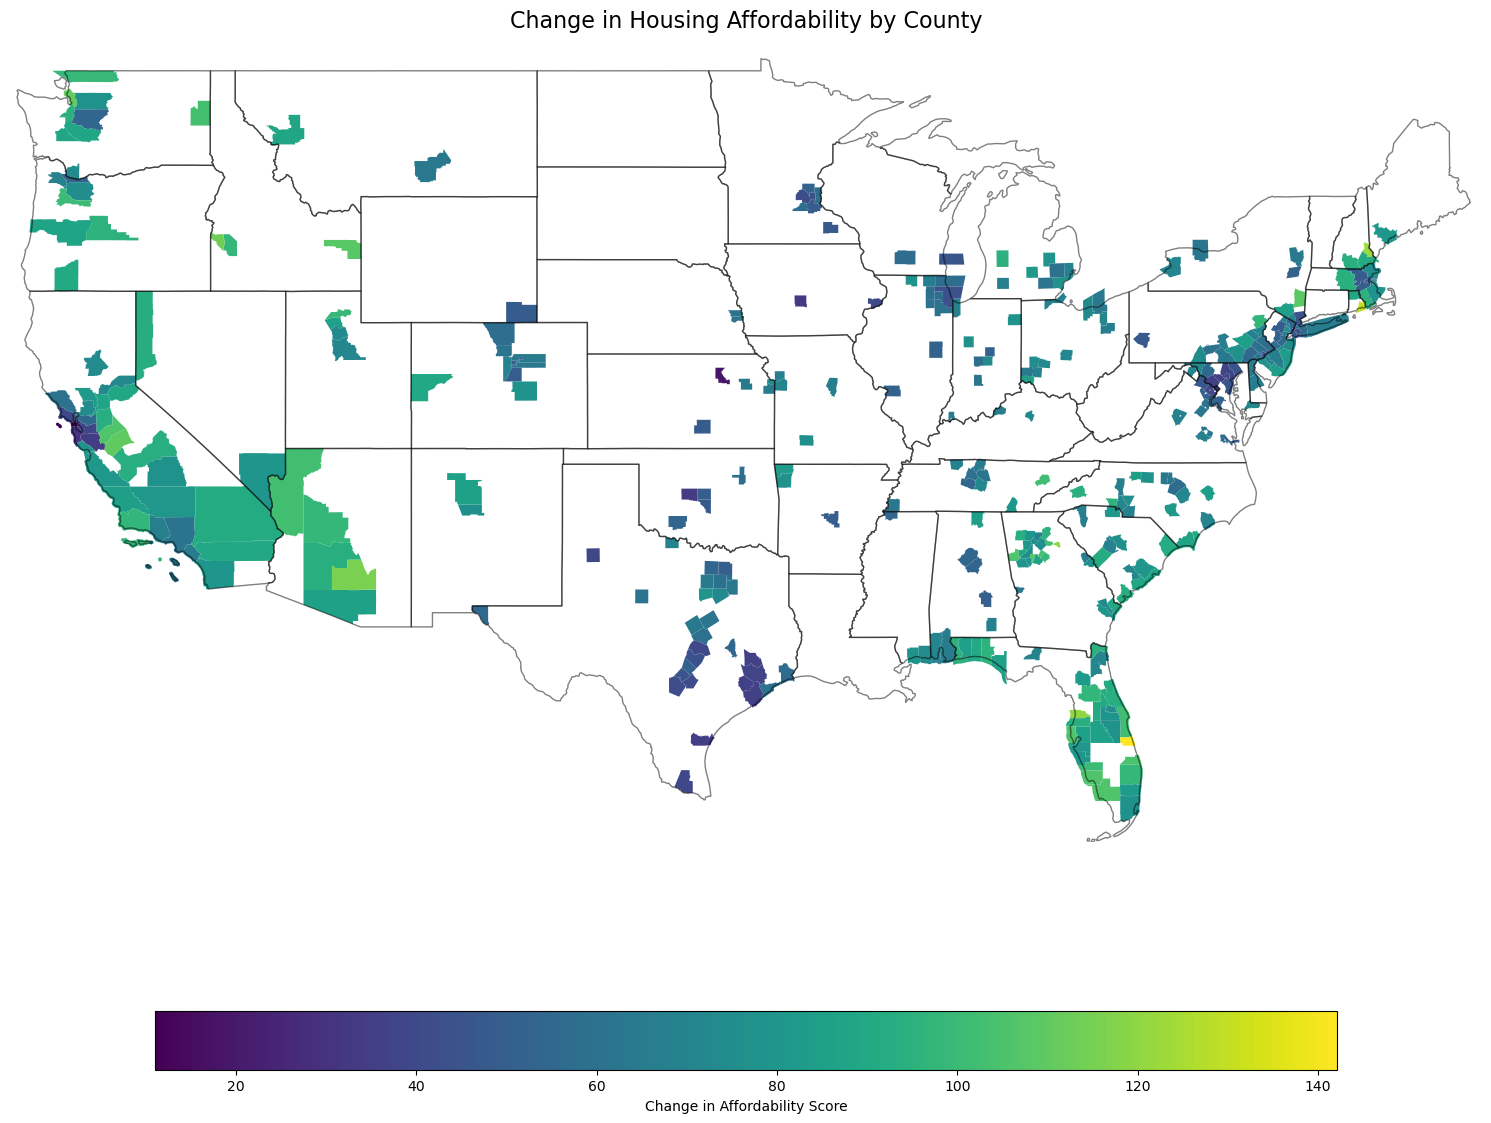

In [15]:
create_choropleth(
    merged_geo,
    'Change_In_Affordability',
    'Change in Housing Affordability by County',
    legend_label='Change in Affordability Score'
)
plt.show()

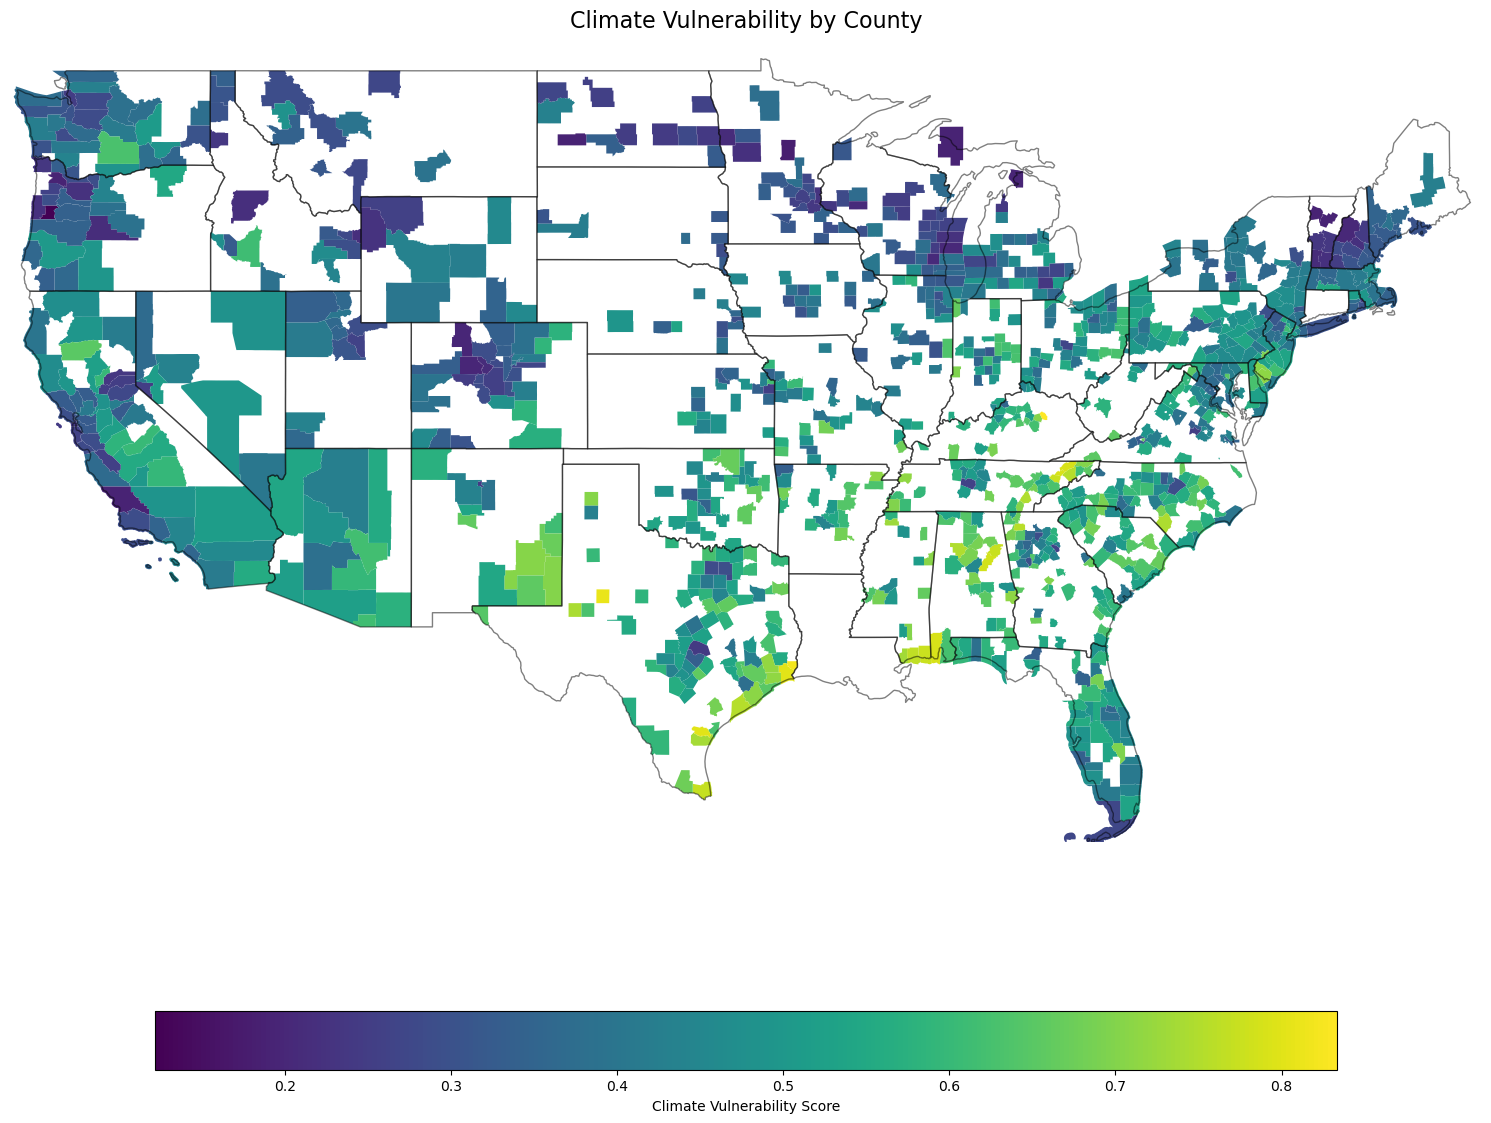

In [16]:
create_choropleth(
    merged_geo,
    'Overall_Climate_Vulnerability',
    'Climate Vulnerability by County',
    legend_label='Climate Vulnerability Score'
)
plt.show()

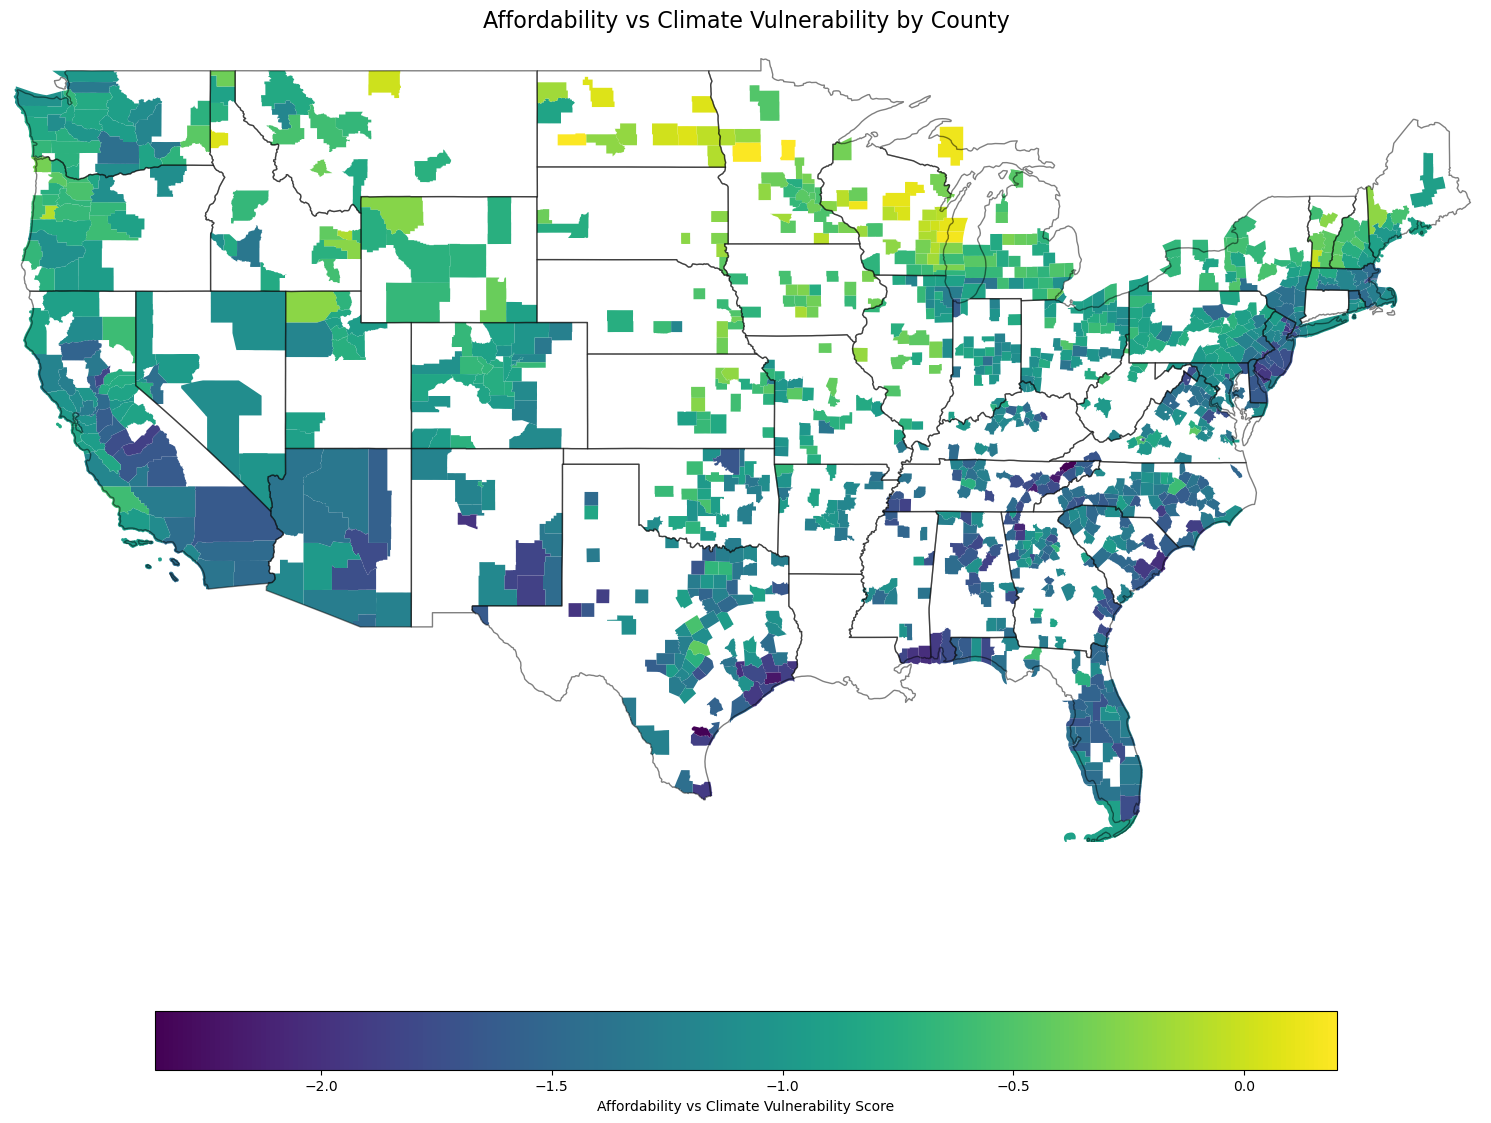

In [17]:
affordability_constant = 0.3

merged_geo['affordability_vs_climate'] = (
    ((merged_geo['Overall_Affordability'] - merged_geo['Overall_Affordability'].min()) / 
    (merged_geo['Overall_Affordability'].max() - merged_geo['Overall_Affordability'].min())) -
    merged_geo['Overall_Climate_Vulnerability'] * affordability_constant ** -1
)


create_choropleth(
    merged_geo,
    'affordability_vs_climate',
    'Affordability vs Climate Vulnerability by County',
    legend_label='Affordability vs Climate Vulnerability Score'
)
plt.show()

### Interpretation
We can interpret the graph above by looking at the colors of each county. The lighter a county is, the more affordable it is, and the less vulnerable it is to climate change. We can see that affordability is a huge problem here - a lot of the counties that are relatively less vulnerable to climate change are also very expensive. San Luis Obispo, Portland, Austin, Milwaukee, Minneapolis/St. Paul, Detroit, and Upstate New York are the urban areas with the strongest balance of affordability and climate vulnerability.

### Correlation
But, are they truly correlated? A geographic visualization is not always the best way to see if two features are correlated. Let's look at the correlation between affordability and climate vulnerability.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Overall Affordability vs Climate Vulnerability'}, xlabel='Climate Vulnerability Score', ylabel='Overall Affordability'>)

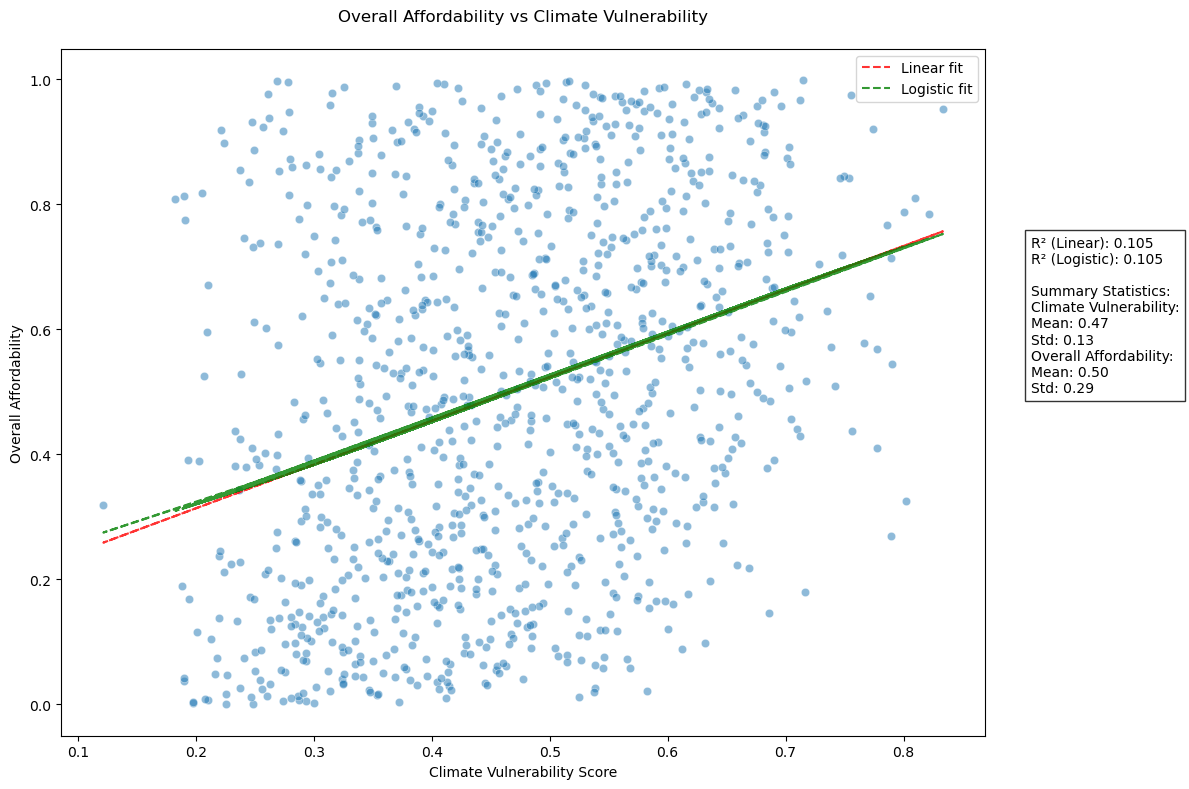

In [18]:
def create_relationship_plots(data):
    """
    Create scatter plot comparing overall affordability with climate vulnerability
    Including both linear and logistic regression fits
    """
    from scipy.optimize import curve_fit
    
    def logistic(x, L, k, x0):
        """Logistic function"""
        return L / (1 + np.exp(-k * (x - x0)))
    
    # Filter to contiguous 48 states
    contiguous_data = data[~((data.index // 1000 == 15) | (data.index // 1000 == 2))]
    
    # Create a single plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Overall Affordability vs Climate Vulnerability
    sns.scatterplot(
        data=contiguous_data,
        x='Overall_Climate_Vulnerability',
        y='Overall_Affordability',
        alpha=0.5,
        ax=ax
    )
    
    # Fit and plot both models
    x = contiguous_data['Overall_Climate_Vulnerability']
    y = contiguous_data['Overall_Affordability']
    
    # Linear fit
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.8, label='Linear fit')
    
    # Logistic fit
    try:
        # Normalize y data to [0,1] for logistic fit
        y_norm = (y - y.min()) / (y.max() - y.min())
        popt, _ = curve_fit(logistic, x, y_norm, p0=[1, 1, np.mean(x)])
        y_fit = logistic(x, *popt) * (y.max() - y.min()) + y.min()
        ax.plot(x, y_fit, "g--", alpha=0.8, label='Logistic fit')
    except:
        print("Could not fit logistic curve")
    
    # Calculate R-squared for both models
    r2_linear = 1 - (np.sum((y - p(x))**2) / np.sum((y - np.mean(y))**2))
    try:
        r2_logistic = 1 - (np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2))
    except:
        r2_logistic = float('nan')
    
    # Add summary stats and R-squared values
    stats_text = (f'R² (Linear): {r2_linear:.3f}\n'
                  f'R² (Logistic): {r2_logistic:.3f}\n\n'
                  f'Summary Statistics:\n'
                  f'Climate Vulnerability:\n'
                  f'Mean: {np.mean(x):.2f}\n'
                  f'Std: {np.std(x):.2f}\n'
                  f'Overall Affordability:\n'
                  f'Mean: {np.mean(y):.2f}\n'
                  f'Std: {np.std(y):.2f}')
    
    ax.text(1.05, 0.5, stats_text, transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.8))
    
    # Customize plot
    ax.set_title('Overall Affordability vs Climate Vulnerability', pad=20)
    ax.set_xlabel('Climate Vulnerability Score')
    ax.set_ylabel('Overall Affordability')
    ax.legend()
    
    plt.tight_layout()
    return fig, ax

# Call the function
create_relationship_plots(merged_geo)

So, among just the data, there isn't really any correlation (a very weak score). We can maybe try filtering by population size. 

Best linear fit with 6 counties (R² = 0.490)
Best logistic fit with 26 counties (R² = 0.268)
Could not fit logistic curve


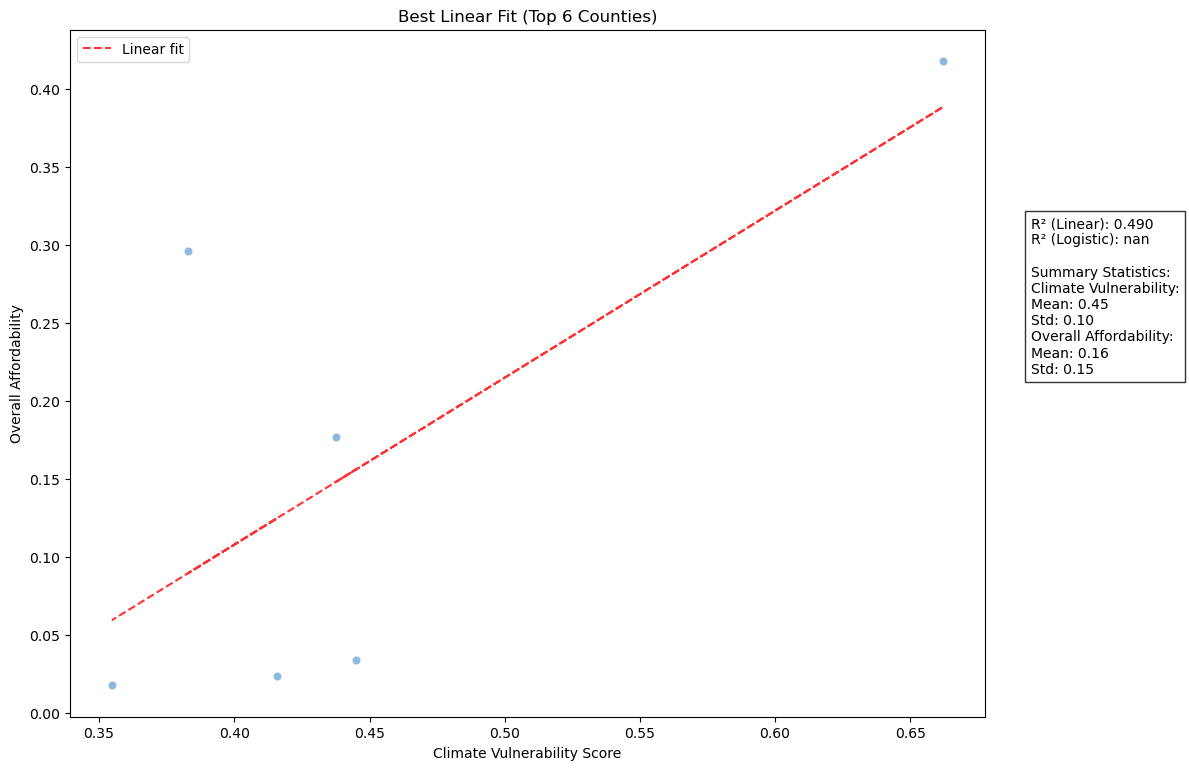

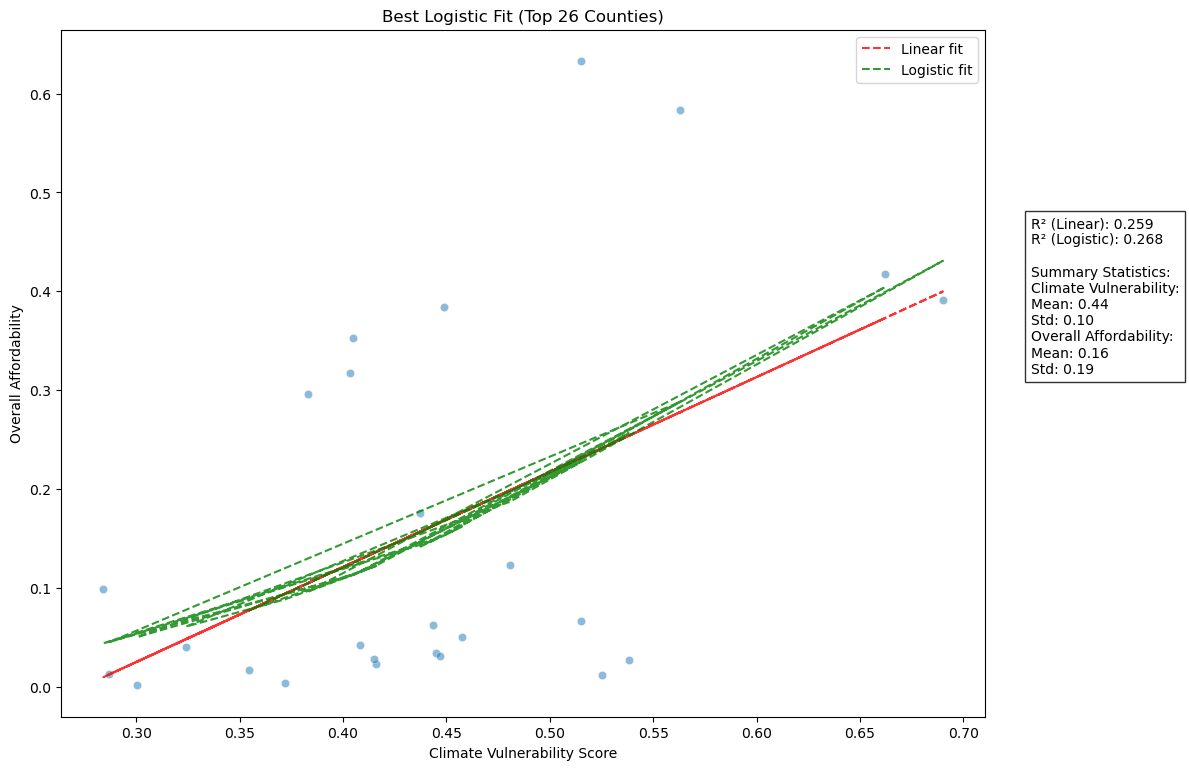

In [19]:
def calculate_fits(data):
    """Calculate linear and logistic fits for the data"""
    from scipy.optimize import curve_fit
    
    def logistic(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))
    
    x = data['Overall_Climate_Vulnerability']
    y = data['Overall_Affordability']
    
    # Linear fit
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    # Logistic fit
    try:
        y_norm = (y - y.min()) / (y.max() - y.min())
        popt, _ = curve_fit(logistic, x, y_norm, p0=[1, 1, np.mean(x)])
        y_fit = logistic(x, *popt) * (y.max() - y.min()) + y.min()
    except:
        y_fit = None
    
    return p, y_fit

max_linear_r2 = 0
max_linear_r2_index = 0
max_logistic_r2 = 0
max_logistic_r2_index = 0

for i in range(4, 100):  # Start from 1 to avoid empty dataframes
    top_i = merged_geo.nsmallest(i, 'SizeRank')
    p, y_fit = calculate_fits(top_i)
    
    # Calculate R² values
    x = top_i['Overall_Climate_Vulnerability']
    y = top_i['Overall_Affordability']
    
    # Linear R²
    r2_linear = 1 - (np.sum((y - p(x))**2) / np.sum((y - np.mean(y))**2))
    
    # Logistic R²
    if y_fit is not None:
        r2_logistic = 1 - (np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2))
    else:
        r2_logistic = 0
    
    if r2_linear > max_linear_r2:
        max_linear_r2 = r2_linear
        max_linear_r2_index = i
    if r2_logistic > max_logistic_r2:
        max_logistic_r2 = r2_logistic
        max_logistic_r2_index = i

print(f"Best linear fit with {max_linear_r2_index} counties (R² = {max_linear_r2:.3f})")
print(f"Best logistic fit with {max_logistic_r2_index} counties (R² = {max_logistic_r2:.3f})")

# Plot both best fits
fig1, ax1 = create_relationship_plots(merged_geo.nsmallest(max_linear_r2_index, 'SizeRank'))
plt.title(f'Best Linear Fit (Top {max_linear_r2_index} Counties)')
plt.show()

fig2, ax2 = create_relationship_plots(merged_geo.nsmallest(max_logistic_r2_index, 'SizeRank'))
plt.title(f'Best Logistic Fit (Top {max_logistic_r2_index} Counties)')
plt.show()

So even at the best, these aren't great. It is indicative that there is some sort of pattern, but also a lot of noise in the data. 

## Machine Learning Models

### K-Means Clustering
We will use the k-means clustering algorithm to find clusters of counties based on affordability and vulnerability, and maybe put them into categories. 

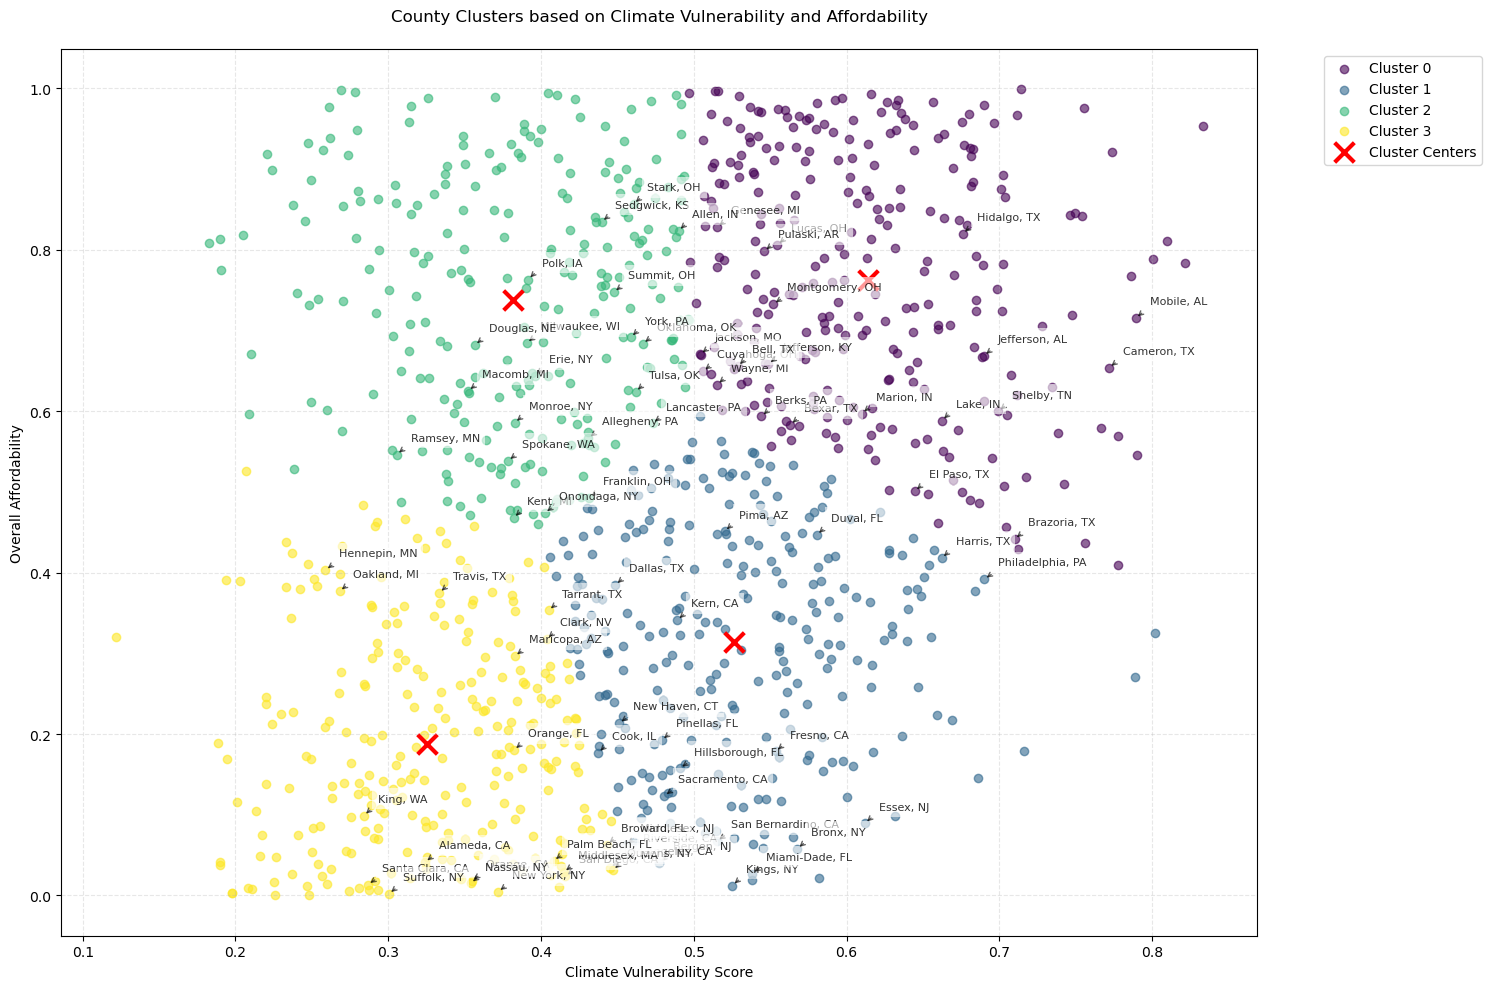

In [20]:
def create_kmeans_clusters(data, n_clusters=4):
    # Prepare the data for clustering
    X = data[['Overall_Climate_Vulnerability', 'Overall_Affordability']].copy()
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels to original data
    data_clustered = data.copy()
    data_clustered['Cluster'] = clusters
    
    # Create visualization with larger figure size
    plt.figure(figsize=(15, 10))
    
    # Create color map
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
    
    # Plot each cluster separately to control legend
    for i in range(n_clusters):
        cluster_data = data_clustered[data_clustered['Cluster'] == i]
        plt.scatter(cluster_data['Overall_Climate_Vulnerability'],
                   cluster_data['Overall_Affordability'],
                   c=[colors[i]], 
                   label=f'Cluster {i}',
                   alpha=0.6)
        
        # Annotate top 30 counties by population (lowest SizeRank) in each cluster
        top_10 = cluster_data.nsmallest(20, 'SizeRank')
        for _, row in top_10.iterrows():
            # Create label with county and state
            label = f"{row['RegionName']}, {row['StateName']}"
            
            # Add annotation with arrow
            plt.annotate(label,
                        (row['Overall_Climate_Vulnerability'], 
                         row['Overall_Affordability']),
                        xytext=(10, 10),
                        textcoords='offset points',
                        fontsize=8,
                        alpha=0.8,
                        bbox=dict(facecolor='white', 
                                edgecolor='none',
                                alpha=0.6),
                        arrowprops=dict(arrowstyle='->',
                                      connectionstyle='arc3,rad=0.2',
                                      alpha=0.6))
    
    # Add cluster centers
    centers = scaler.inverse_transform(kmeans.cluster_centers_)
    plt.scatter(centers[:, 0], centers[:, 1], 
               c='red', marker='x', s=200, linewidths=3, 
               label='Cluster Centers')
    
    # Customize plot
    plt.title('County Clusters based on Climate Vulnerability and Affordability'
             ,pad=20)
    plt.xlabel('Climate Vulnerability Score')
    plt.ylabel('Overall Affordability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return data_clustered, kmeans, scaler

# Run clustering with optimal number of clusters (use the number suggested by elbow method)
clustered_data, kmeans_model, scaler = create_kmeans_clusters(merged_geo, n_clusters=4)

On first glance, this looks like an awkward fit. But, these clusters make sense. The purple cluster are affordable but vulnerable, the green clusters are affordable and relatively less vulnerable, the blue clusters are less affordable and more vulnerable, and the yellow clusters are less affordable and less vulnerable.

Obviously, we want to be in the green! The green cluster tells us more about places that are cheaper AND more vulnerable to climate change. Lancaster, Nebraska; Douglas, Nebraska; Polk, Iowa are the highlights here. 

/var/folders/9w/zgdt459s4994dgldr004clnw0000gn/T/ipykernel_16048/4035048156.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


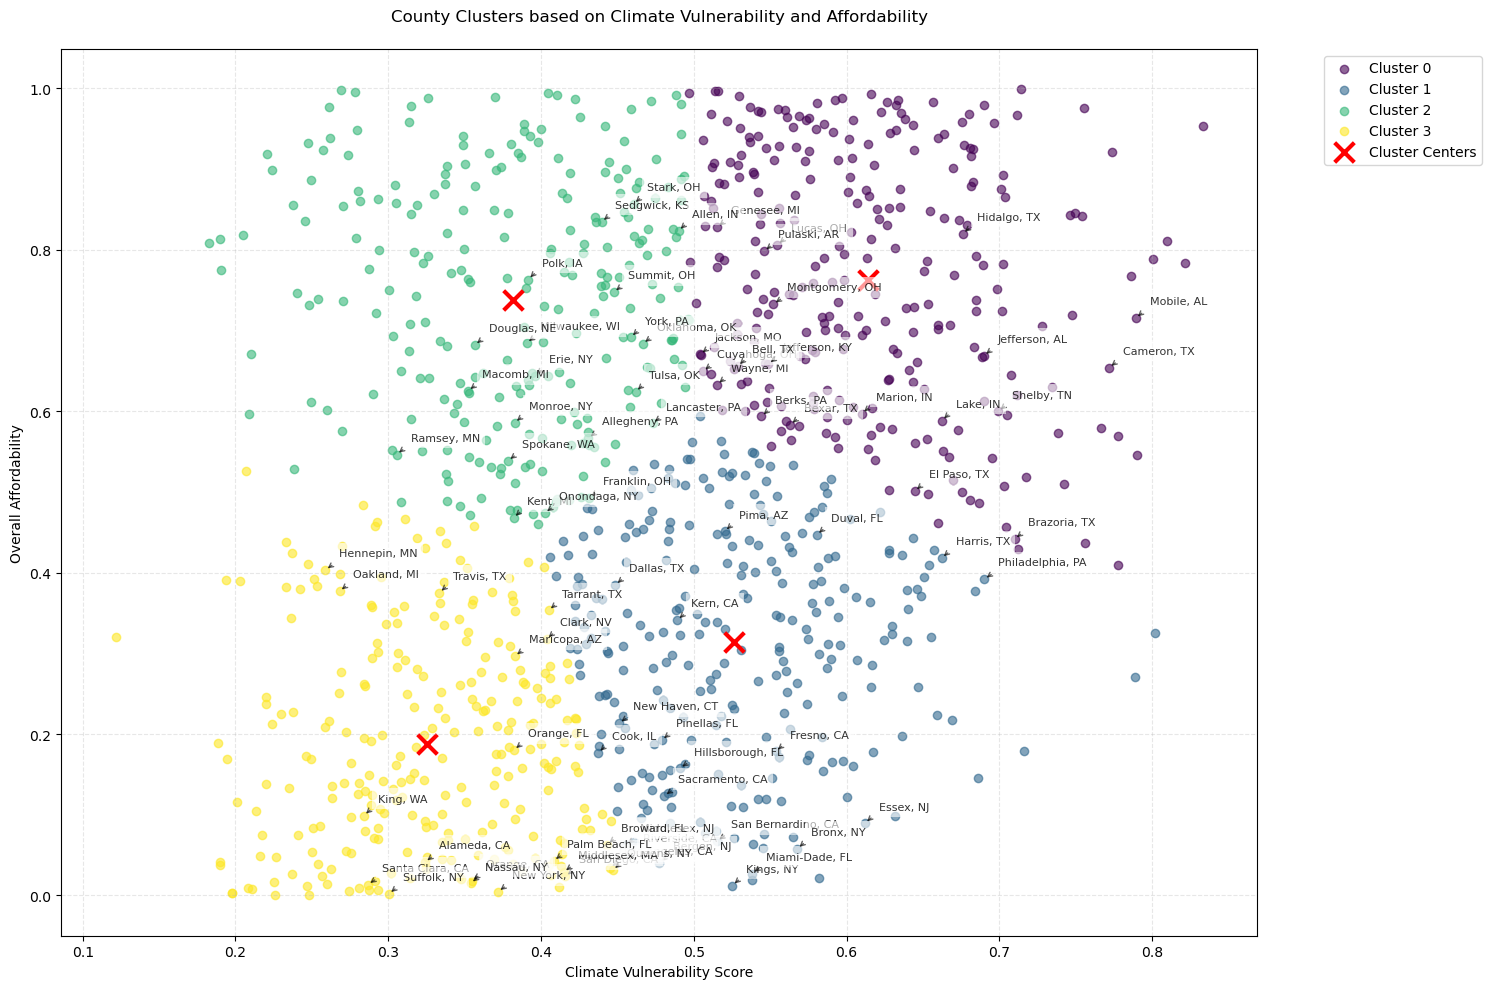

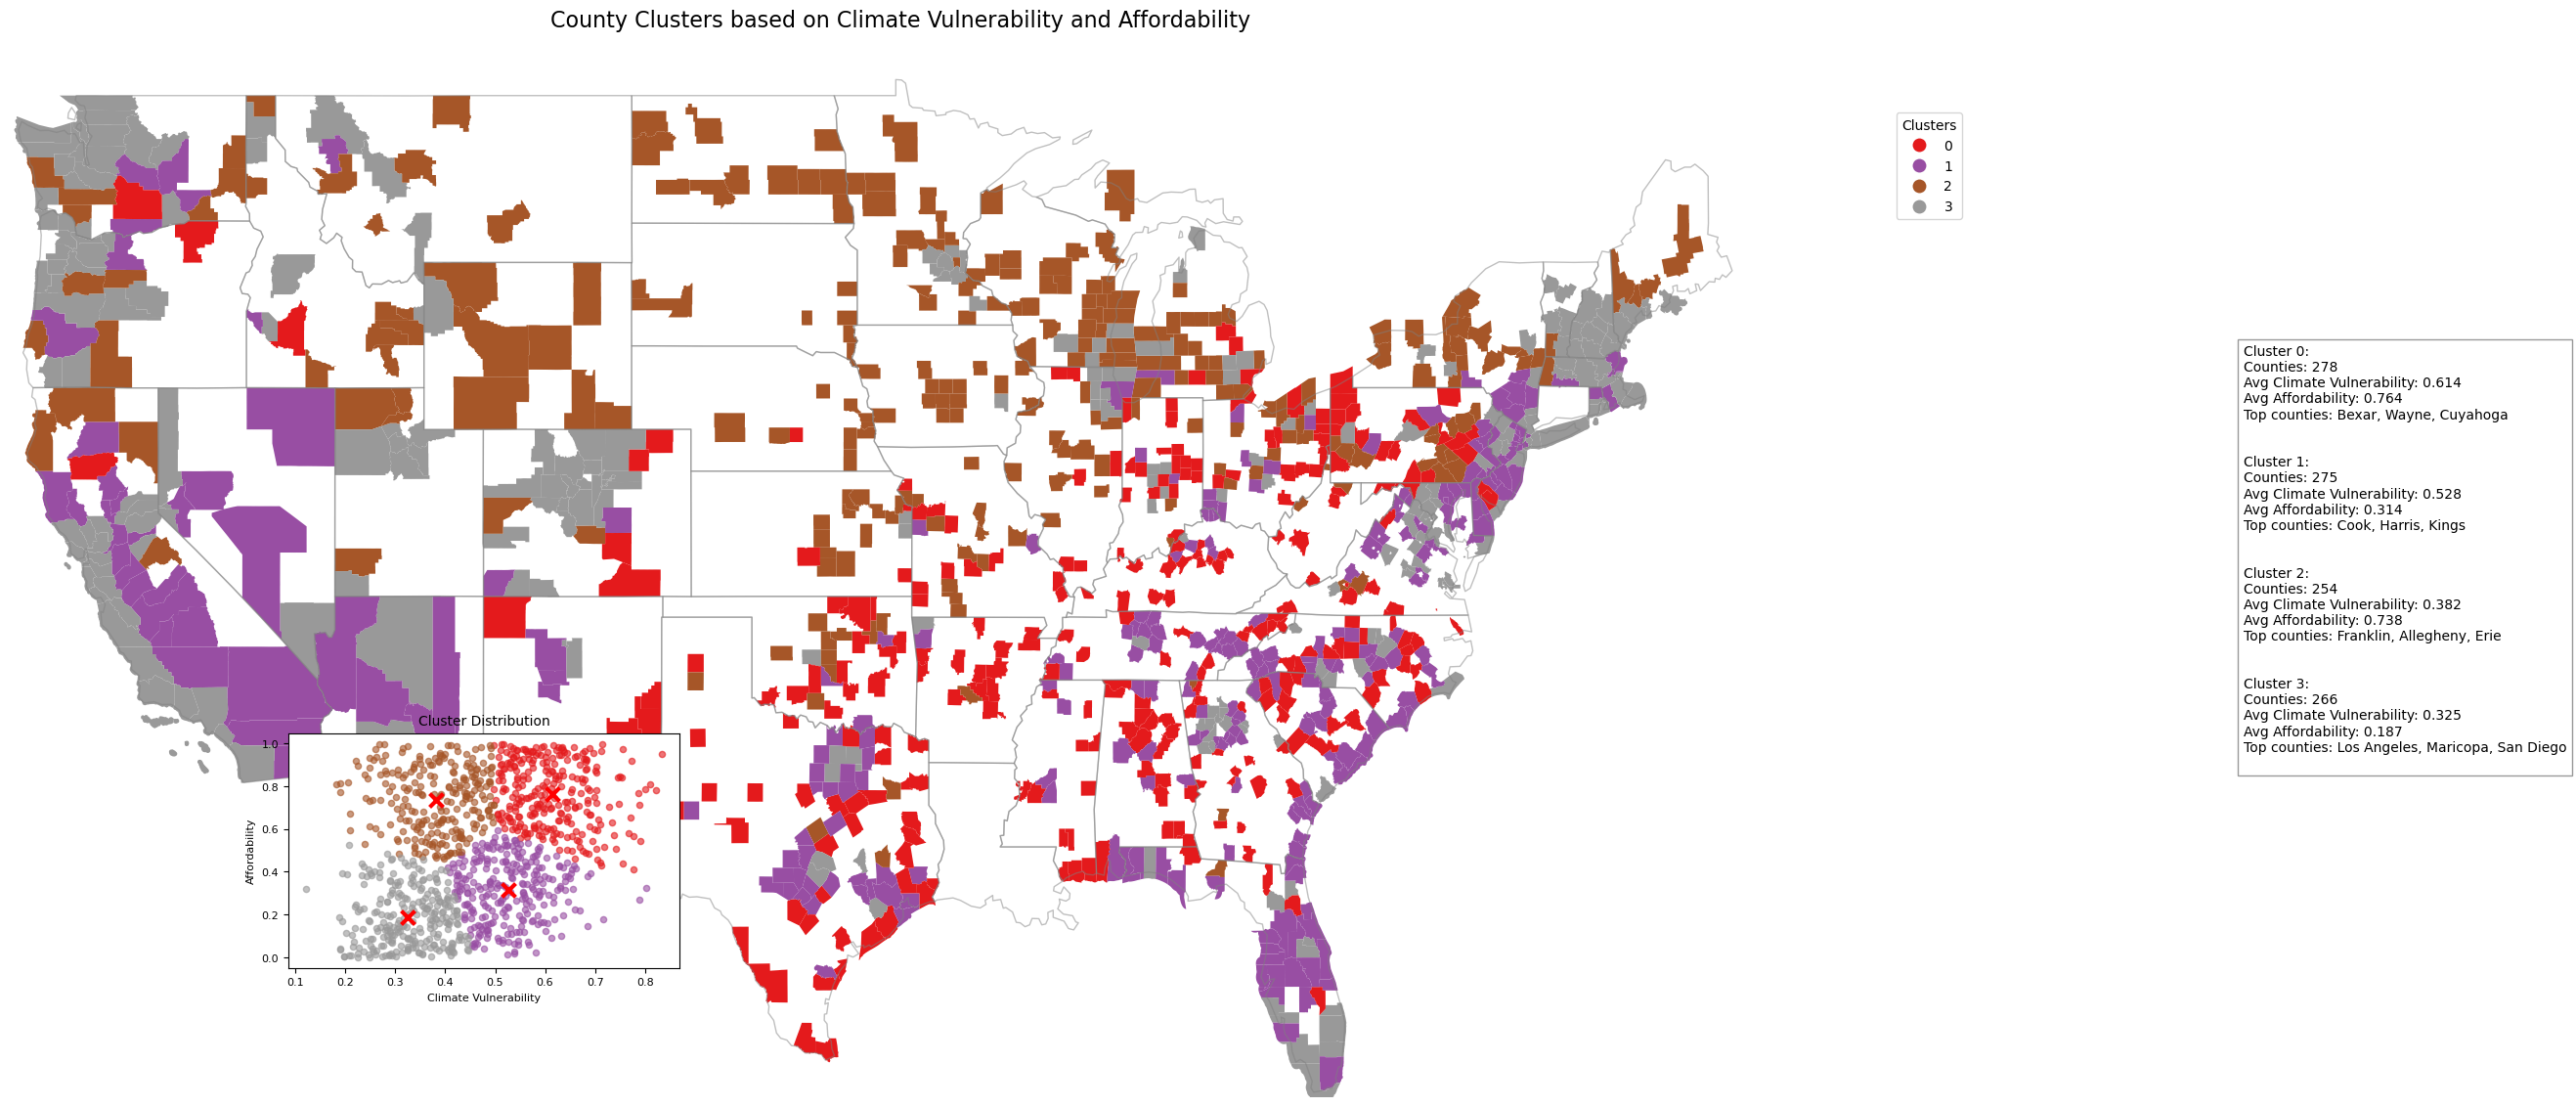

In [21]:
def create_cluster_map(data_clustered, n_clusters=4):
    """
    Create a choropleth map showing k-means clusters using matplotlib
    """
    import matplotlib.pyplot as plt
    import geopandas as gpd
    
    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    
    # Create color map
    colors = plt.cm.Set1(np.linspace(0, 1, n_clusters))
    
    # Plot the map
    data_clustered.plot(
        column='Cluster',
        categorical=True,
        cmap='Set1',
        legend=True,
        legend_kwds={
            'title': 'Clusters',
            'bbox_to_anchor': (1.1, 0.95)
        },
        ax=ax
    )
    
    # Add state borders with lighter color
    states = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")
    states.boundary.plot(ax=ax, linewidth=1, color='gray', alpha=0.5)
    
    # Customize the map
    ax.axis('off')
    ax.set_xlim([-125, -65])
    ax.set_ylim([25, 50])
    ax.set_title('County Clusters based on Climate Vulnerability and Affordability',
                 pad=20, size=16)
    
    # Add cluster statistics as text box
    stats_text = []
    for i in range(n_clusters):
        cluster_data = data_clustered[data_clustered['Cluster'] == i]
        stats = (
            f"Cluster {i}:\n"
            f"Counties: {len(cluster_data)}\n"
            f"Avg Climate Vulnerability: {cluster_data['Overall_Climate_Vulnerability'].mean():.3f}\n"
            f"Avg Affordability: {cluster_data['Overall_Affordability'].mean():.3f}\n"
            f"Top counties: {', '.join(cluster_data.nsmallest(3, 'SizeRank')['RegionName'])}\n"
        )
        stats_text.append(stats)
    
    # Add text box with statistics
    plt.figtext(
        1.15, 0.5, '\n\n'.join(stats_text),
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
        fontsize=10,
        verticalalignment='center'
    )
    
    # Add scatter plot showing relationship
    # Create small subplot for scatter
    ax_scatter = fig.add_axes([0.15, 0.15, 0.2, 0.2])
    
    # Plot points colored by cluster
    for i in range(n_clusters):
        cluster_data = data_clustered[data_clustered['Cluster'] == i]
        ax_scatter.scatter(
            cluster_data['Overall_Climate_Vulnerability'],
            cluster_data['Overall_Affordability'],
            c=[colors[i]],
            label=f'Cluster {i}',
            alpha=0.6,
            s=20
        )
    
    # Add cluster centers to scatter plot
    centers = scaler.inverse_transform(kmeans_model.cluster_centers_)
    ax_scatter.scatter(
        centers[:, 0], centers[:, 1],
        c='red', marker='x', s=100, linewidths=3,
        label='Centers'
    )
    
    ax_scatter.set_xlabel('Climate Vulnerability', fontsize=8)
    ax_scatter.set_ylabel('Affordability', fontsize=8)
    ax_scatter.tick_params(labelsize=8)
    ax_scatter.set_title('Cluster Distribution', fontsize=10)

    
    plt.tight_layout()
    
    return fig, ax

# Create the map
clustered_data, kmeans_model, scaler = create_kmeans_clusters(merged_geo, n_clusters=4)
fig, ax = create_cluster_map(clustered_data)
plt.show()



Finally, we can create a composite livability score with higher weight for climate resilience and population bonus. Here is the breakdown for how we calculate the livability score: 60% of the livability score is based on climate vulnerability; 30%, affordability; and 10%, population (to account for the fact that larger population = more livable). We use Random Forest to classify whether a county is good or bad based on the livability score, as a test of our model. We also use Gradient Boosting to predict the livability score.


Top 10 Most Livable Counties:
      RegionName StateName  Livability_Score  Overall_Affordability  \
888    Sheboygan        WI          0.815250               0.898601   
614     Marathon        WI          0.813689               0.932692   
752   Otter Tail        MN          0.810303               0.918706   
613    Manitowoc        WI          0.810108               0.976399   
234    Crow Wing        MN          0.802629               0.809003   
288   Eau Claire        WI          0.800824               0.818182   
368  Grand Forks        ND          0.796103               0.937937   
995         Ward        ND          0.794021               0.923951   
623    Marquette        MI          0.787727               0.774476   
796      Portage        WI          0.787720               0.886364   

     Overall_Climate_Vulnerability  SizeRank  
888                       0.224081       538  
614                       0.247671       474  
752                       0.220945       886  

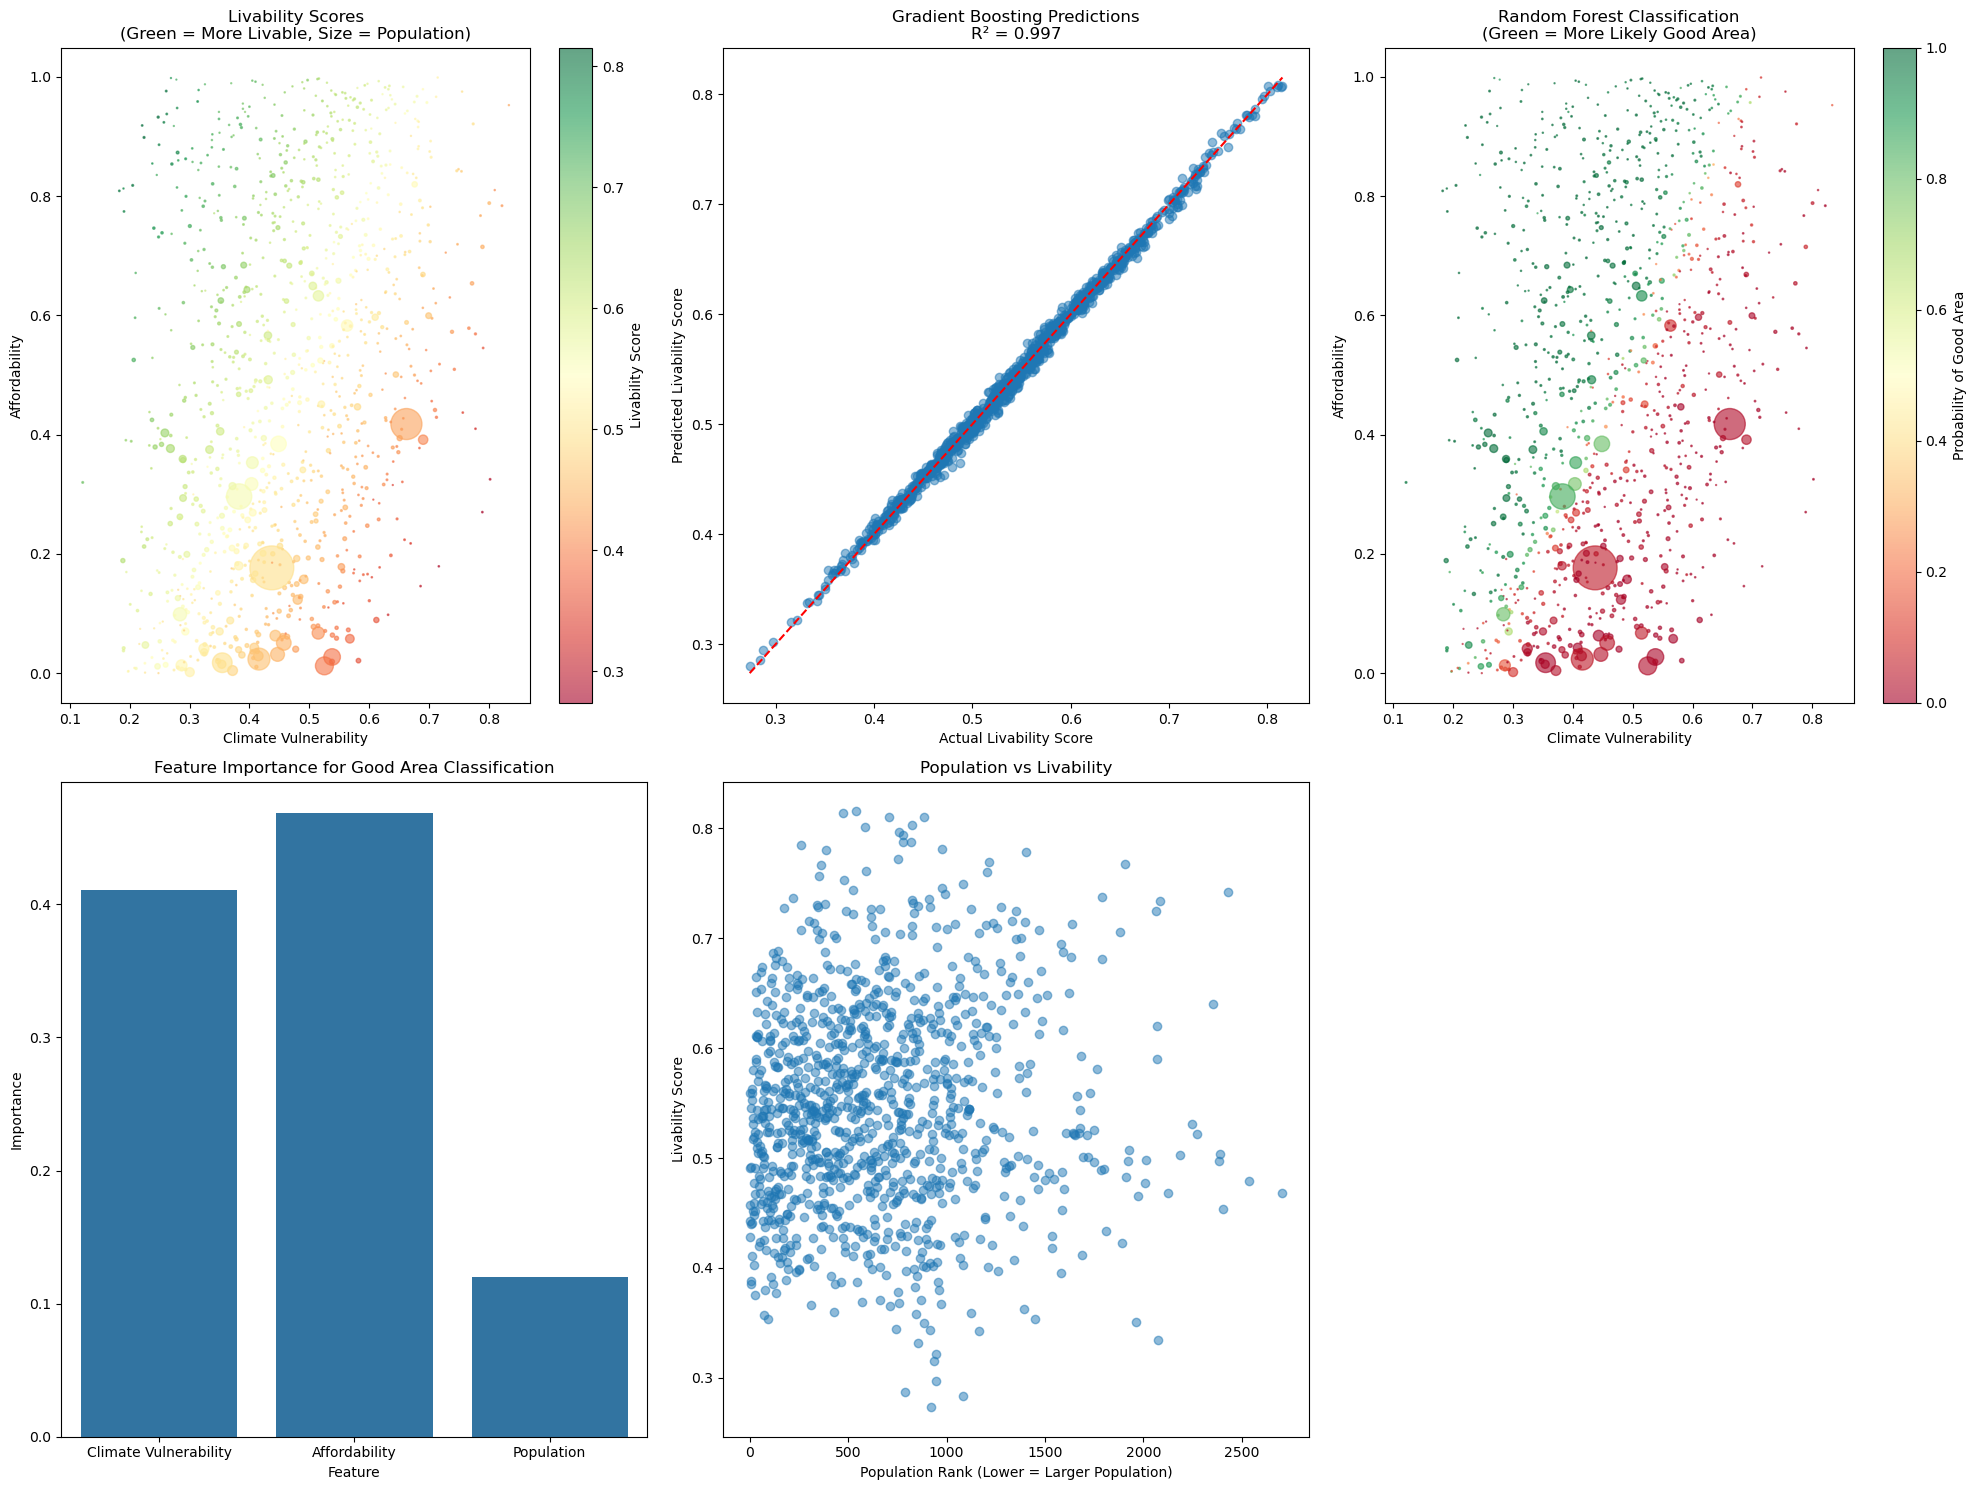

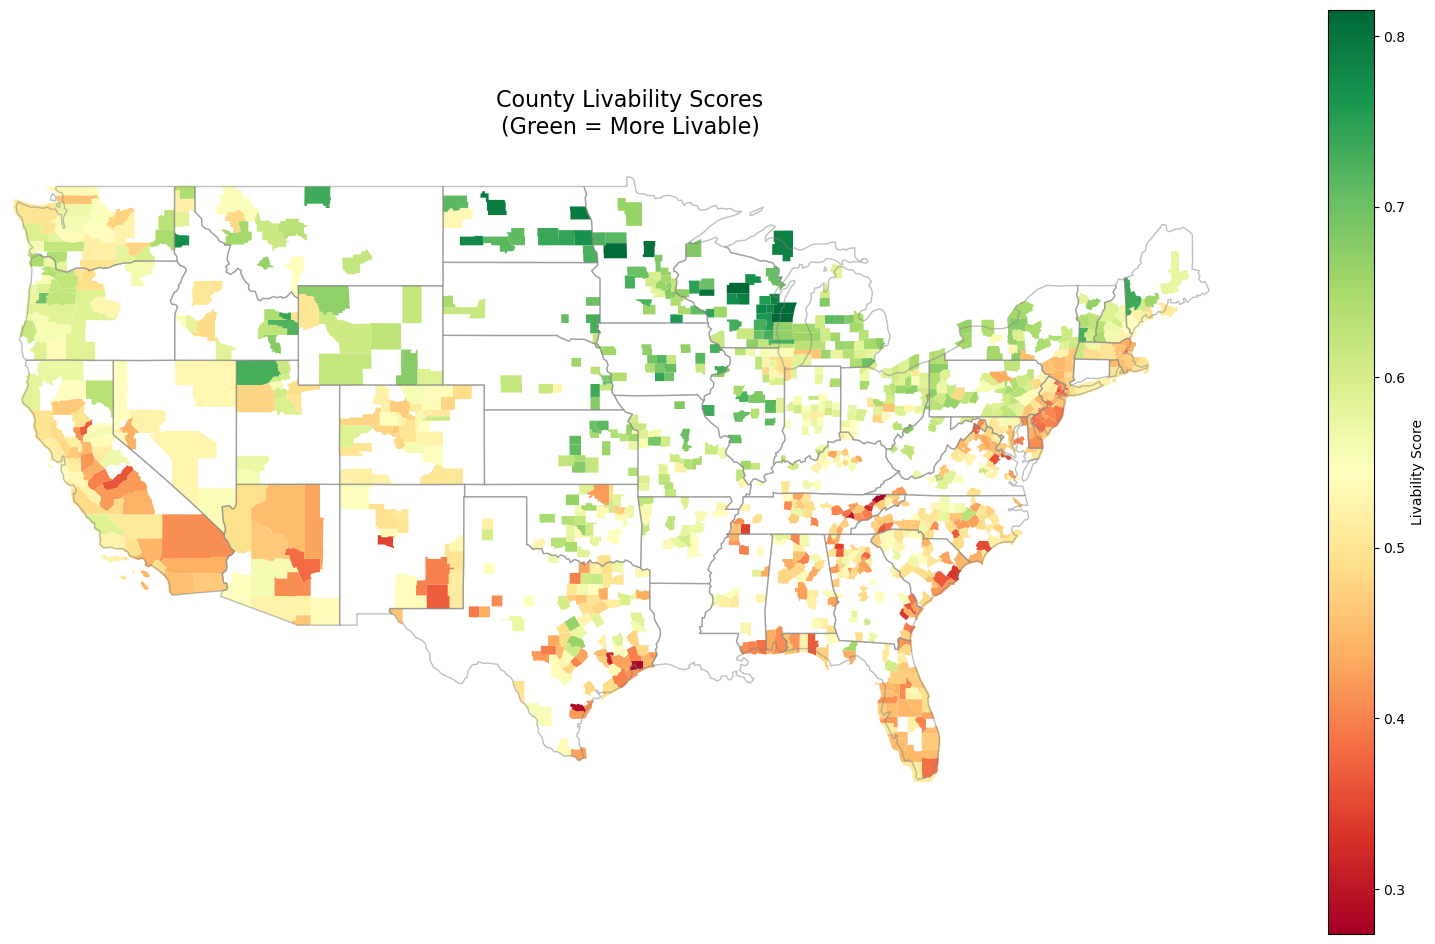

In [22]:
def create_livability_analysis(data):
    """
    Create and compare different models for analyzing area livability
    with higher weight for climate resilience and population bonus
    """
    # 1. Create a composite livability score with modified weights
    def calculate_livability_score(row, climate_weight=0.6, population_weight=0.1):
        # Normalize SizeRank to 0-1 (inverse so larger population = higher score)
        max_rank = data['SizeRank'].max()
        population_score = 1 - (row['SizeRank'] / max_rank)
        
        # Calculate climate resilience (inverted vulnerability)
        climate_resilience = 1 - row['Overall_Climate_Vulnerability']
        
        # Combine scores with weights
        affordability_weight = 1 - climate_weight - population_weight
        return (climate_weight * climate_resilience + 
                affordability_weight * row['Overall_Affordability'] +
                population_weight * population_score)
    
    # Create the base dataset with livability score
    data_with_scores = data.copy()
    data_with_scores['Livability_Score'] = data.apply(calculate_livability_score, axis=1)
    
    # Create binary classification target (above/below median livability)
    median_livability = data_with_scores['Livability_Score'].median()
    data_with_scores['Good_Area'] = (data_with_scores['Livability_Score'] > median_livability).astype(int)
    
    # Prepare features (now including SizeRank)
    X = data_with_scores[['Overall_Climate_Vulnerability', 'Overall_Affordability', 'SizeRank']].values
    y_score = data_with_scores['Livability_Score'].values
    y_binary = data_with_scores['Good_Area'].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create visualizations
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Scatter plot with livability scores
    ax1 = fig.add_subplot(231)
    scatter = ax1.scatter(X[:, 0], X[:, 1], c=y_score, cmap='RdYlGn', 
                         alpha=0.6, s=100/data_with_scores['SizeRank']*10)  # Size by population
    ax1.set_xlabel('Climate Vulnerability')
    ax1.set_ylabel('Affordability')
    ax1.set_title('Livability Scores\n(Green = More Livable, Size = Population)')
    plt.colorbar(scatter, ax=ax1, label='Livability Score')
    
    # 2. Gradient Boosting Regression
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_model.fit(X_scaled, y_score)
    gb_pred = gb_model.predict(X_scaled)
    
    ax2 = fig.add_subplot(232)
    ax2.scatter(y_score, gb_pred, alpha=0.5)
    ax2.plot([y_score.min(), y_score.max()], [y_score.min(), y_score.max()], 'r--')
    ax2.set_xlabel('Actual Livability Score')
    ax2.set_ylabel('Predicted Livability Score')
    ax2.set_title(f'Gradient Boosting Predictions\nR² = {r2_score(y_score, gb_pred):.3f}')
    
    # 3. Random Forest Classification
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_scaled, y_binary)
    rf_pred_proba = rf_model.predict_proba(X_scaled)[:, 1]
    
    ax3 = fig.add_subplot(233)
    scatter = ax3.scatter(X[:, 0], X[:, 1], c=rf_pred_proba, cmap='RdYlGn', 
                         alpha=0.6, s=100/data_with_scores['SizeRank']*10)
    ax3.set_xlabel('Climate Vulnerability')
    ax3.set_ylabel('Affordability')
    ax3.set_title('Random Forest Classification\n(Green = More Likely Good Area)')
    plt.colorbar(scatter, ax=ax3, label='Probability of Good Area')
    
    # 4. Feature Importance
    ax4 = fig.add_subplot(234)
    feature_importance = pd.DataFrame({
        'Feature': ['Climate Vulnerability', 'Affordability', 'Population'],
        'Importance': rf_model.feature_importances_
    })
    sns.barplot(data=feature_importance, x='Feature', y='Importance', ax=ax4)
    ax4.set_title('Feature Importance for Good Area Classification')
    
    # 5. Population vs Livability
    ax5 = fig.add_subplot(235)
    ax5.scatter(data_with_scores['SizeRank'], data_with_scores['Livability_Score'], 
                alpha=0.5)
    ax5.set_xlabel('Population Rank (Lower = Larger Population)')
    ax5.set_ylabel('Livability Score')
    ax5.set_title('Population vs Livability')
    
    plt.tight_layout()
    
    # Create map visualization
    fig_map, ax_map = plt.subplots(1, 1, figsize=(20, 12))
    
    # Filter out Alaska and Hawaii
    contiguous_data = data_with_scores[~((data_with_scores.index // 1000 == 2) | 
                                       (data_with_scores.index // 1000 == 15))]
    
    # Plot the map
    contiguous_data.plot(
        column='Livability_Score',
        cmap='RdYlGn',
        legend=True,
        legend_kwds={'label': 'Livability Score'},
        ax=ax_map
    )
    
    # Add state borders
    states = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")
    states = states[~states.name.isin(['Alaska', 'Hawaii'])]
    states.boundary.plot(ax=ax_map, linewidth=1, color='gray', alpha=0.5)
    
    # Customize the map
    ax_map.axis('off')
    ax_map.set_title('County Livability Scores\n(Green = More Livable)',
                     pad=20, size=16)
    
    # Set map extent
    ax_map.set_xlim([-125, -65])
    ax_map.set_ylim([25, 50])
    
    # Print analysis results
    print("\nTop 10 Most Livable Counties:")
    top_10 = data_with_scores.nlargest(10, 'Livability_Score')
    print(top_10[['RegionName', 'StateName', 'Livability_Score', 
                  'Overall_Affordability', 'Overall_Climate_Vulnerability', 'SizeRank']])
    
    print("\nTop 10 Most Livable Large Counties (Top 100 by population):")
    large_counties = data_with_scores[data_with_scores['SizeRank'] <= 100]
    top_10_large = large_counties.nlargest(10, 'Livability_Score')
    print(top_10_large[['RegionName', 'StateName', 'Livability_Score', 
                        'Overall_Affordability', 'Overall_Climate_Vulnerability', 'SizeRank']])
    
    # Model performance metrics
    print("\nModel Performance:")
    print("\nGradient Boosting Regression (Livability Score Prediction):")
    print(f"R² Score: {r2_score(y_score, gb_pred):.3f}")
    
    print("\nRandom Forest Classification (Good/Bad Area):")
    rf_pred = rf_model.predict(X_scaled)
    print("\nClassification Report:")
    print(classification_report(y_binary, rf_pred, 
                              target_names=['Less Livable', 'More Livable']))
    
    return data_with_scores, gb_model, rf_model, scaler

# Run the analysis
data_with_scores, gb_model, rf_model, scaler = create_livability_analysis(merged_geo)
plt.show()